In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

- 날짜는 그때그때 변경

In [2]:
date = '0619'

In [3]:
CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'IMG_SIZE':224,
    'EPOCHS':50,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':8,
    'SEED':1203
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### zip파일 압축 해제

In [5]:
import zipfile
import os

# ZIP 파일 경로와 추출 경로를 지정합니다.
zip_file_path = '/content/drive/MyDrive/image classification/open.zip'
extract_to_path = '/content/data'

# 추출 경로가 존재하지 않으면 생성합니다.
if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

# ZIP 파일을 열고 추출합니다.
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### weather에 대한 라벨 변경

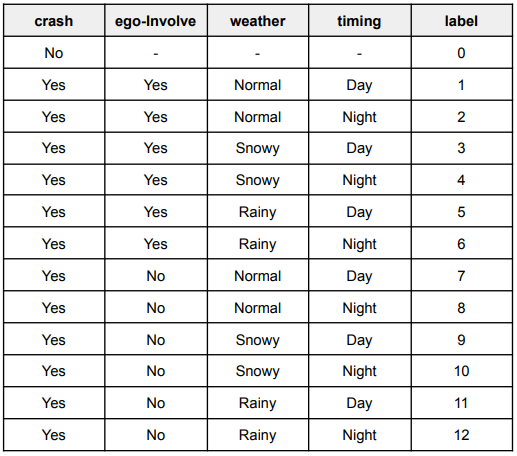

In [11]:
df = pd.read_csv('/content/data/train.csv')

df.loc[df['sample_id'].isin(['TRAIN_2236', 'TRAIN_2596']), 'label'] = 0
df.loc[df['sample_id'].isin(['TRAIN_0061', 'TRAIN_0107', 'TRAIN_0123', 'TRAIN_0294',
    'TRAIN_0800', 'TRAIN_1280', 'TRAIN_1590', 'TRAIN_2302', 'TRAIN_2548']), 'label'] = 1
df.loc[df['sample_id'].isin(['TRAIN_0056', 'TRAIN_0129', 'TRAIN_0149', 'TRAIN_0242',
    'TRAIN_0263', 'TRAIN_0728', 'TRAIN_0861', 'TRAIN_0889', 'TRAIN_0896', 'TRAIN_0920', 'TRAIN_1098',
    'TRAIN_1169', 'TRAIN_1251', 'TRAIN_1605', 'TRAIN_1654', 'TRAIN_1656', 'TRAIN_1698', 'TRAIN_1795',
    'TRAIN_1839', 'TRAIN_1955', 'TRAIN_2249', 'TRAIN_2388', 'TRAIN_2647']), 'label'] = 3
df.loc[df['sample_id'].isin(['TRAIN_0221', 'TRAIN_0856', 'TRAIN_1081', 'TRAIN_1263',
    'TRAIN_1488', 'TRAIN_1492', 'TRAIN_1874', 'TRAIN_2166', 'TRAIN_2555', 'TRAIN_2595', 'TRAIN_2622']),
    'label'] = 4
df.loc[df['sample_id'].isin(['TRAIN_0017', 'TRAIN_0225', 'TRAIN_0306', 'TRAIN_1193',
    'TRAIN_1771', 'TRAIN_1848', 'TRAIN_2140', 'TRAIN_2298', 'TRAIN_2532', 'TRAIN_2570']), 'label'] = 5
df.loc[df['sample_id'].isin(['TRAIN_0809']), 'label'] = 6
df.loc[df['sample_id'].isin(['TRAIN_0020', 'TRAIN_0507', 'TRAIN_0617', 'TRAIN_1023',
    'TRAIN_1420', 'TRAIN_1531', 'TRAIN_2033', 'TRAIN_2063']), 'label'] = 7
df.loc[df['sample_id'].isin(['TRAIN_0332', 'TRAIN_0674', 'TRAIN_0720', 'TRAIN_0917',
    'TRAIN_1287', 'TRAIN_1699', 'TRAIN_1923', 'TRAIN_1949', 'TRAIN_2239', 'TRAIN_2491', 'TRAIN_2534', 'TRAIN_2615']), 'label'] = 9
df.loc[df['sample_id'].isin(['TRAIN_0877', 'TRAIN_1728', 'TRAIN_2328', 'TRAIN_2685']), 'label'] = 10
df.loc[df['sample_id'].isin(['TRAIN_0341', 'TRAIN_1041', 'TRAIN_1581', 'TRAIN_1727', 'TRAIN_2607']), 'label'] = 11
df.loc[df['sample_id'].isin(['TRAIN_2571']), 'label'] = 12

# 삭제할 sample_id 리스트
del_list = ['TRAIN_0048', 'TRAIN_0234', 'TRAIN_0238', 'TRAIN_0325', 'TRAIN_0528', 'TRAIN_0554', 'TRAIN_0668',
                  'TRAIN_0705', 'TRAIN_0875', 'TRAIN_1082', 'TRAIN_1151', 'TRAIN_1337', 'TRAIN_1362', 'TRAIN_1506',
                  'TRAIN_1674', 'TRAIN_1681', 'TRAIN_1753', 'TRAIN_1838', 'TRAIN_2191', 'TRAIN_2356', 'TRAIN_2360',
                  'TRAIN_2428', 'TRAIN_2451', 'TRAIN_2486', 'TRAIN_2558', 'TRAIN_2658']

In [12]:
# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성
df = df[~df['sample_id'].isin(del_list)]
df = df.drop(df[df['label'] == 0].index)

normal_list = [1, 2, 7, 8]
snowy_list = [3, 4, 9, 10]
rainy_list = [5, 6, 11, 12]

df.loc[df['label'].isin(normal_list), 'label']=0
df.loc[df['label'].isin(snowy_list), 'label']=1
df.loc[df['label'].isin(rainy_list), 'label']=2
df['video_path'] = df['video_path'].str.replace('./train', '/content/data/train')
df['label'].value_counts()

label
0    634
1    171
2     83
Name: count, dtype: int64

In [13]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.25, random_state=CFG['SEED'])

### 증강 적용
- https://dacon.io/competitions/official/236064/codeshare/7571?page=2&dtype=recent

In [14]:
class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list, tfms):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.tfms = tfms

    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])

        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames

    def __len__(self):
        return len(self.video_path_list)

    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for _ in range(CFG['VIDEO_LENGTH']):
            _, img = cap.read()
            frames.append(img)
        frames = aug_video(frames, tfms=self.tfms)
        return torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2)

def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

tfms_train = A.Compose([
            A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
            A.HorizontalFlip(p=0.5),
            # A.RandomCrop(width=CFG['IMG_SIZE'] - 10, height=CFG['IMG_SIZE'] - 10, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(p=0.2),
            A.Normalize()
            ], p=1)

tfms_val = A.Compose([
    A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
    A.Normalize()
], p=1)

In [15]:
train_dataset = CustomDataset(train['video_path'].values, train['label'].values, tfms=tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=1)
val_dataset = CustomDataset(val['video_path'].values, val['label'].values, tfms=tfms_val)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=1)

## Train

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_max = 0

    def __call__(self, val_score, model, model_path):
        score = val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(score, model, model_path)

    def save_checkpoint(self, val_score, model, model_path):
        if val_score > self.val_score_max:
            print(f'Validation score increased ({self.val_score_max:.6f} --> {val_score:.6f}).  Saving model ...')
            torch.save(model.state_dict(), model_path)
        self.val_score_max = val_score

def train_ftn(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    early_stop = EarlyStopping(patience=5, delta=0.001)
    best_val_score = 0
    best_model = None

    train_loss_epoch, valid_loss_epoch, valid_score_epoch = [], [], []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(videos)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

        train_loss_epoch.append(_train_loss)
        valid_loss_epoch.append(_val_loss)
        valid_score_epoch.append(_val_score)

        if scheduler is not None:
            scheduler.step(_val_score)

        early_stop(_val_score, model, '/content/drive/MyDrive/image classification/params/weather/weather_r3d_weights_' + date + '_1.pth')

        if early_stop.early_stop:
            print("Early stopping")
            break

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('***** Best Model *****')
            # torch.save(best_model.state_dict(), '/content/drive/MyDrive/image classification/params/weather/weather_r3d_weights_' + date + '_1.pth')

    return best_model, train_loss_epoch, valid_loss_epoch, valid_score_epoch, best_val_score

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []

    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)

            logit = model(videos)

            loss = criterion(logit, labels)

            val_loss.append(loss.item())

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()

        _val_loss = np.mean(val_loss)

    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)

            logit = model(videos)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [18]:
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [ ]:
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)

# 마지막 분류레이어만 학습
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# 모델 freeze
for param in model.parameters():
    param.requires_grad = False

# layer4의 파라미터들을 학습 가능하도록 설정
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

In [17]:
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)

# 마지막 분류레이어만 학습
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 169MB/s]


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.94314] Val Loss : [0.94248] Val F1 : [0.27094]
Validation score increased (0.000000 --> 0.270945).  Saving model ...
***** Best Model *****


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.85097] Val Loss : [0.88740] Val F1 : [0.27200]
Validation score increased (0.270945 --> 0.272000).  Saving model ...
***** Best Model *****


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.80877] Val Loss : [0.85278] Val F1 : [0.27200]
EarlyStopping counter: 1 out of 5


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.79861] Val Loss : [0.83601] Val F1 : [0.27200]
EarlyStopping counter: 2 out of 5


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.77321] Val Loss : [0.82741] Val F1 : [0.27200]
EarlyStopping counter: 3 out of 5


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.77057] Val Loss : [0.82071] Val F1 : [0.27200]
EarlyStopping counter: 4 out of 5


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.76513] Val Loss : [0.81544] Val F1 : [0.27200]
EarlyStopping counter: 5 out of 5
Early stopping


ValueError: too many values to unpack (expected 4)

### Stratified K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG['SEED'])

scores_list = []
model_list = []

for fold, (train_index, val_index) in enumerate(skf.split(df, df['label'])):
    train = df.iloc[train_index]
    val = df.iloc[val_index]

    print(f"Fold {fold}:")
    print(f"Train set size: {len(train)}, Validation set size: {len(val)}")

    # CustomDataset 및 DataLoader 설정
    train_dataset = CustomDataset(train['video_path'].values, train['label'].values, tfms=tfms_train)
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val['video_path'].values, val['label'].values, tfms=tfms_val)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    model = models.video.r3d_18(pretrained = True)
    model.fc = nn.Linear(in_features=512, out_features=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

    infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_, val_score = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

    train_dataset, train_loader = None, None
    val_dataset, val_loader = None, None

    scores_list.append(val_score)
    model_list.append(infer_model)

# score_list 중 가장 높은 값의 index에 해당하는 모델을 best_model로 저장
best_model = model_list[scores_list.index(max(scores_list))]
torch.save(best_model.state_dict(), '/content/drive/MyDrive/image classification/params/weather/weather_r3d_kfold_weights_0602_1.pth')

Fold 0:
Train set size: 710, Validation set size: 178


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.88460] Val Loss : [0.68514] Val F1 : [0.46124]
Validation score increased (0.000000 --> 0.461235).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.63773] Val Loss : [0.52200] Val F1 : [0.60489]
Validation score increased (0.461235 --> 0.604891).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.48546] Val Loss : [0.42525] Val F1 : [0.69353]
Validation score increased (0.604891 --> 0.693528).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.38143] Val Loss : [0.36238] Val F1 : [0.66836]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.32662] Val Loss : [0.33449] Val F1 : [0.67111]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.27279] Val Loss : [0.33876] Val F1 : [0.79259]
Validation score increased (0.693528 --> 0.792590).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.25038] Val Loss : [0.32094] Val F1 : [0.69917]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.18991] Val Loss : [0.34613] Val F1 : [0.76158]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.13710] Val Loss : [0.29867] Val F1 : [0.78206]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13081] Val Loss : [0.32148] Val F1 : [0.74687]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.12498] Val Loss : [0.32933] Val F1 : [0.79602]
Validation score increased (0.792590 --> 0.796021).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.11729] Val Loss : [0.31390] Val F1 : [0.73060]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.09517] Val Loss : [0.30845] Val F1 : [0.75825]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.08854] Val Loss : [0.34994] Val F1 : [0.73973]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.07092] Val Loss : [0.32232] Val F1 : [0.74065]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.06109] Val Loss : [0.34372] Val F1 : [0.76889]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 1:
Train set size: 710, Validation set size: 178


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.91086] Val Loss : [0.72826] Val F1 : [0.73229]
Validation score increased (0.000000 --> 0.732289).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.64336] Val Loss : [0.52081] Val F1 : [0.74684]
Validation score increased (0.732289 --> 0.746835).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.49728] Val Loss : [0.42399] Val F1 : [0.77976]
Validation score increased (0.746835 --> 0.779759).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.39191] Val Loss : [0.37366] Val F1 : [0.83267]
Validation score increased (0.779759 --> 0.832665).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.34659] Val Loss : [0.33850] Val F1 : [0.84201]
Validation score increased (0.832665 --> 0.842006).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.30352] Val Loss : [0.28903] Val F1 : [0.84289]
EarlyStopping counter: 1 out of 5
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.23893] Val Loss : [0.28826] Val F1 : [0.88006]
Validation score increased (0.842006 --> 0.880055).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.19717] Val Loss : [0.24310] Val F1 : [0.86583]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.16975] Val Loss : [0.24680] Val F1 : [0.86583]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13216] Val Loss : [0.25020] Val F1 : [0.82584]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.13056] Val Loss : [0.23790] Val F1 : [0.86286]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.12204] Val Loss : [0.22399] Val F1 : [0.86583]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 2:
Train set size: 710, Validation set size: 178


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.02343] Val Loss : [0.86722] Val F1 : [0.38596]
Validation score increased (0.000000 --> 0.385956).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.72691] Val Loss : [0.67738] Val F1 : [0.60708]
Validation score increased (0.385956 --> 0.607077).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.53956] Val Loss : [0.50879] Val F1 : [0.64856]
Validation score increased (0.607077 --> 0.648557).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.40416] Val Loss : [0.44609] Val F1 : [0.70915]
Validation score increased (0.648557 --> 0.709150).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.33945] Val Loss : [0.42717] Val F1 : [0.71633]
Validation score increased (0.709150 --> 0.716326).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.27673] Val Loss : [0.40414] Val F1 : [0.69731]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.23301] Val Loss : [0.37269] Val F1 : [0.71497]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.18980] Val Loss : [0.34343] Val F1 : [0.72190]
Validation score increased (0.716326 --> 0.721898).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.16306] Val Loss : [0.36571] Val F1 : [0.70846]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.15603] Val Loss : [0.35521] Val F1 : [0.70795]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.13436] Val Loss : [0.37372] Val F1 : [0.70949]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.10719] Val Loss : [0.35900] Val F1 : [0.71633]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.10439] Val Loss : [0.37192] Val F1 : [0.72454]
Validation score increased (0.721898 --> 0.724538).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.08465] Val Loss : [0.35472] Val F1 : [0.73800]
Validation score increased (0.724538 --> 0.737999).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.07473] Val Loss : [0.37391] Val F1 : [0.73118]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.06909] Val Loss : [0.39319] Val F1 : [0.68871]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.07374] Val Loss : [0.40261] Val F1 : [0.72428]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.04526] Val Loss : [0.37142] Val F1 : [0.72045]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.07514] Val Loss : [0.37067] Val F1 : [0.72179]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 3:
Train set size: 711, Validation set size: 177


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.04311] Val Loss : [0.93953] Val F1 : [0.39088]
Validation score increased (0.000000 --> 0.390875).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.72876] Val Loss : [0.74240] Val F1 : [0.53971]
Validation score increased (0.390875 --> 0.539709).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.52420] Val Loss : [0.57690] Val F1 : [0.67198]
Validation score increased (0.539709 --> 0.671977).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.42726] Val Loss : [0.54903] Val F1 : [0.68019]
Validation score increased (0.671977 --> 0.680189).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.33550] Val Loss : [0.51731] Val F1 : [0.72750]
Validation score increased (0.680189 --> 0.727498).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.29622] Val Loss : [0.52642] Val F1 : [0.73172]
Validation score increased (0.727498 --> 0.731716).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.27912] Val Loss : [0.48562] Val F1 : [0.70627]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.21944] Val Loss : [0.50152] Val F1 : [0.72485]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.18612] Val Loss : [0.50263] Val F1 : [0.74482]
Validation score increased (0.731716 --> 0.744818).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.15822] Val Loss : [0.50308] Val F1 : [0.73424]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.11875] Val Loss : [0.51899] Val F1 : [0.73681]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.11771] Val Loss : [0.50211] Val F1 : [0.74910]
Validation score increased (0.744818 --> 0.749104).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.10716] Val Loss : [0.56833] Val F1 : [0.74471]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.09619] Val Loss : [0.56673] Val F1 : [0.72485]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.08254] Val Loss : [0.57582] Val F1 : [0.72485]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.07943] Val Loss : [0.54063] Val F1 : [0.75961]
Validation score increased (0.749104 --> 0.759614).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.06982] Val Loss : [0.60137] Val F1 : [0.72896]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.07235] Val Loss : [0.60584] Val F1 : [0.72896]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.06692] Val Loss : [0.68199] Val F1 : [0.74754]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.06663] Val Loss : [0.63066] Val F1 : [0.73990]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.05629] Val Loss : [0.61127] Val F1 : [0.73244]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 4:
Train set size: 711, Validation set size: 177


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.00382] Val Loss : [0.79920] Val F1 : [0.51242]
Validation score increased (0.000000 --> 0.512419).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.70798] Val Loss : [0.62669] Val F1 : [0.60509]
Validation score increased (0.512419 --> 0.605087).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.53761] Val Loss : [0.43143] Val F1 : [0.74016]
Validation score increased (0.605087 --> 0.740158).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.42178] Val Loss : [0.36582] Val F1 : [0.78809]
Validation score increased (0.740158 --> 0.788092).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.34924] Val Loss : [0.38643] Val F1 : [0.82919]
Validation score increased (0.788092 --> 0.829186).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.30827] Val Loss : [0.28538] Val F1 : [0.88831]
Validation score increased (0.829186 --> 0.888307).  Saving model ...
***** Best Model *****


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.25821] Val Loss : [0.27435] Val F1 : [0.88165]
EarlyStopping counter: 1 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.23508] Val Loss : [0.27531] Val F1 : [0.85168]
EarlyStopping counter: 2 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.19271] Val Loss : [0.25896] Val F1 : [0.87484]
EarlyStopping counter: 3 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14866] Val Loss : [0.24341] Val F1 : [0.86326]
EarlyStopping counter: 4 out of 5


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.13813] Val Loss : [0.24515] Val F1 : [0.83030]
EarlyStopping counter: 5 out of 5
Early stopping


In [ ]:
max(scores_list)

0.8883067810457517

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG['SEED'])

scores_list = []
model_list = []

for fold, (train_index, val_index) in enumerate(skf.split(df, df['label'])):
    train = df.iloc[train_index]
    val = df.iloc[val_index]

    print(f"Fold {fold}:")
    print(f"Train set size: {len(train)}, Validation set size: {len(val)}")

    # CustomDataset 및 DataLoader 설정
    train_dataset = CustomDataset(train['video_path'].values, train['label'].values, tfms=tfms_train)
    train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val['video_path'].values, val['label'].values, tfms=tfms_val)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    model = models.video.r3d_18(pretrained = True)
    model.fc = nn.Linear(in_features=512, out_features=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

    infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_, val_score = train_ftn(model, optimizer, train_loader, val_loader, scheduler, device)

    train_dataset, train_loader = None, None
    val_dataset, val_loader = None, None

    scores_list.append(val_score)
    model_list.append(infer_model)

# score_list 중 가장 높은 값의 index에 해당하는 모델을 best_model로 저장
best_model = model_list[scores_list.index(max(scores_list))]
torch.save(best_model.state_dict(), '')

Fold 0:
Train set size: 710, Validation set size: 178


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.20589] Val Loss : [0.93837] Val F1 : [0.43258]
Validation score increased (0.000000 --> 0.432584).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.76583] Val Loss : [0.52211] Val F1 : [0.61719]
Validation score increased (0.432584 --> 0.617194).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.52279] Val Loss : [0.48249] Val F1 : [0.71665]
Validation score increased (0.617194 --> 0.716654).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.41329] Val Loss : [0.40722] Val F1 : [0.75850]
Validation score increased (0.716654 --> 0.758504).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.31272] Val Loss : [0.31799] Val F1 : [0.74866]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.25878] Val Loss : [0.35320] Val F1 : [0.75402]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.24635] Val Loss : [0.32810] Val F1 : [0.73400]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.19626] Val Loss : [0.35705] Val F1 : [0.79444]
Validation score increased (0.758504 --> 0.794441).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.19270] Val Loss : [0.33841] Val F1 : [0.78473]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14989] Val Loss : [0.31023] Val F1 : [0.81430]
Validation score increased (0.794441 --> 0.814303).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.13148] Val Loss : [0.34052] Val F1 : [0.80467]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.11475] Val Loss : [0.37095] Val F1 : [0.74440]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.10451] Val Loss : [0.32742] Val F1 : [0.77843]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.08388] Val Loss : [0.33570] Val F1 : [0.80076]
EarlyStopping counter: 4 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09618] Val Loss : [0.34624] Val F1 : [0.80805]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 1:
Train set size: 710, Validation set size: 178


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.17436] Val Loss : [1.00443] Val F1 : [0.26798]
Validation score increased (0.000000 --> 0.267978).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.72524] Val Loss : [0.55023] Val F1 : [0.71378]
Validation score increased (0.267978 --> 0.713781).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.52890] Val Loss : [0.44452] Val F1 : [0.75221]
Validation score increased (0.713781 --> 0.752207).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.39732] Val Loss : [0.39243] Val F1 : [0.76140]
Validation score increased (0.752207 --> 0.761396).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.30782] Val Loss : [0.34968] Val F1 : [0.80888]
Validation score increased (0.761396 --> 0.808879).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.26913] Val Loss : [0.35987] Val F1 : [0.77983]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.19072] Val Loss : [0.33873] Val F1 : [0.79099]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.17569] Val Loss : [0.33163] Val F1 : [0.78288]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.13657] Val Loss : [0.34369] Val F1 : [0.79767]
EarlyStopping counter: 4 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.12720] Val Loss : [0.33577] Val F1 : [0.79410]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 2:
Train set size: 710, Validation set size: 178


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.75072] Val Loss : [0.60909] Val F1 : [0.47732]
Validation score increased (0.000000 --> 0.477324).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.52163] Val Loss : [0.47680] Val F1 : [0.56904]
Validation score increased (0.477324 --> 0.569039).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.40510] Val Loss : [0.40744] Val F1 : [0.71320]
Validation score increased (0.569039 --> 0.713205).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.31449] Val Loss : [0.37515] Val F1 : [0.67429]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.25129] Val Loss : [0.35658] Val F1 : [0.70041]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.19781] Val Loss : [0.34518] Val F1 : [0.69846]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.16381] Val Loss : [0.37277] Val F1 : [0.70071]
EarlyStopping counter: 4 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15033] Val Loss : [0.38156] Val F1 : [0.68031]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 3:
Train set size: 711, Validation set size: 177


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.76373] Val Loss : [0.65038] Val F1 : [0.48912]
Validation score increased (0.000000 --> 0.489123).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.54887] Val Loss : [0.52626] Val F1 : [0.57731]
Validation score increased (0.489123 --> 0.577314).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.40456] Val Loss : [0.45672] Val F1 : [0.62747]
Validation score increased (0.577314 --> 0.627475).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.31526] Val Loss : [0.45828] Val F1 : [0.70725]
Validation score increased (0.627475 --> 0.707249).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.27937] Val Loss : [0.43448] Val F1 : [0.67840]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.20603] Val Loss : [0.45521] Val F1 : [0.68277]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.20387] Val Loss : [0.46560] Val F1 : [0.70335]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15687] Val Loss : [0.48910] Val F1 : [0.73407]
Validation score increased (0.707249 --> 0.734073).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.11950] Val Loss : [0.49550] Val F1 : [0.75496]
Validation score increased (0.734073 --> 0.754960).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.10630] Val Loss : [0.45698] Val F1 : [0.71543]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.09222] Val Loss : [0.46799] Val F1 : [0.71273]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.07754] Val Loss : [0.49519] Val F1 : [0.71975]
EarlyStopping counter: 3 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08929] Val Loss : [0.50815] Val F1 : [0.68405]
EarlyStopping counter: 4 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.06034] Val Loss : [0.48040] Val F1 : [0.72947]
EarlyStopping counter: 5 out of 5
Early stopping
Fold 4:
Train set size: 711, Validation set size: 177


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.27691] Val Loss : [0.92856] Val F1 : [0.55151]
Validation score increased (0.000000 --> 0.551508).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.78038] Val Loss : [0.67079] Val F1 : [0.69639]
Validation score increased (0.551508 --> 0.696387).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.54649] Val Loss : [0.43811] Val F1 : [0.76125]
Validation score increased (0.696387 --> 0.761255).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.42928] Val Loss : [0.36869] Val F1 : [0.82494]
Validation score increased (0.761255 --> 0.824939).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.33611] Val Loss : [0.37137] Val F1 : [0.83078]
Validation score increased (0.824939 --> 0.830781).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.26878] Val Loss : [0.32891] Val F1 : [0.81999]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.22134] Val Loss : [0.30427] Val F1 : [0.85598]
Validation score increased (0.830781 --> 0.855975).  Saving model ...
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.19966] Val Loss : [0.29151] Val F1 : [0.84156]
EarlyStopping counter: 1 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.15541] Val Loss : [0.29767] Val F1 : [0.85045]
EarlyStopping counter: 2 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13679] Val Loss : [0.30547] Val F1 : [0.85647]
EarlyStopping counter: 3 out of 5
***** Best Model *****


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.11958] Val Loss : [0.34127] Val F1 : [0.82573]
EarlyStopping counter: 4 out of 5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.09414] Val Loss : [0.30875] Val F1 : [0.83595]
EarlyStopping counter: 5 out of 5
Early stopping


RuntimeError: [enforce fail at inline_container.cc:633] . invalid file name: 

In [ ]:
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 222MB/s]


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.86985] Val Loss : [0.70719] Val F1 : [0.57467]
Validation score increased (0.000000 --> 0.574672).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.60390] Val Loss : [0.50789] Val F1 : [0.67684]
Validation score increased (0.574672 --> 0.676844).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.45743] Val Loss : [0.44928] Val F1 : [0.71435]
Validation score increased (0.676844 --> 0.714348).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.34941] Val Loss : [0.36229] Val F1 : [0.74260]
Validation score increased (0.714348 --> 0.742599).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.28763] Val Loss : [0.36834] Val F1 : [0.79444]
Validation score increased (0.742599 --> 0.794444).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.23385] Val Loss : [0.35817] Val F1 : [0.78995]
EarlyStopping counter: 1 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.20750] Val Loss : [0.35177] Val F1 : [0.78244]
EarlyStopping counter: 2 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15237] Val Loss : [0.33930] Val F1 : [0.79942]
Validation score increased (0.794444 --> 0.799418).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.11598] Val Loss : [0.33314] Val F1 : [0.78685]
EarlyStopping counter: 1 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.12187] Val Loss : [0.38294] Val F1 : [0.80533]
Validation score increased (0.799418 --> 0.805327).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.10447] Val Loss : [0.33241] Val F1 : [0.77878]
EarlyStopping counter: 1 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.07756] Val Loss : [0.36507] Val F1 : [0.78895]
EarlyStopping counter: 2 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.06690] Val Loss : [0.35927] Val F1 : [0.76271]
EarlyStopping counter: 3 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.06740] Val Loss : [0.35916] Val F1 : [0.78995]
EarlyStopping counter: 4 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.06464] Val Loss : [0.38637] Val F1 : [0.80688]
Validation score increased (0.805327 --> 0.806885).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.04877] Val Loss : [0.34259] Val F1 : [0.82093]
Validation score increased (0.806885 --> 0.820928).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.04082] Val Loss : [0.37112] Val F1 : [0.81817]
EarlyStopping counter: 1 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.05813] Val Loss : [0.36007] Val F1 : [0.81401]
EarlyStopping counter: 2 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.05326] Val Loss : [0.39017] Val F1 : [0.79581]
EarlyStopping counter: 3 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.03338] Val Loss : [0.37195] Val F1 : [0.80388]
EarlyStopping counter: 4 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.03569] Val Loss : [0.34493] Val F1 : [0.84702]
Validation score increased (0.820928 --> 0.847020).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.03418] Val Loss : [0.39758] Val F1 : [0.81247]
EarlyStopping counter: 1 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.03577] Val Loss : [0.39685] Val F1 : [0.77950]
EarlyStopping counter: 2 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.02299] Val Loss : [0.38390] Val F1 : [0.79101]
EarlyStopping counter: 3 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.04126] Val Loss : [0.45391] Val F1 : [0.75684]
EarlyStopping counter: 4 out of 5


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.03303] Val Loss : [0.41584] Val F1 : [0.76823]
EarlyStopping counter: 5 out of 5
Early stopping


In [ ]:
model = models.video.swin3d_t(pretrained = True)
model.head = nn.Linear(in_features=768, out_features=3)

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.72896] Val Loss : [0.64015] Val F1 : [0.28606]
Validation score decreased (inf --> 0.286061).  Saving model ...
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.52553] Val Loss : [0.48819] Val F1 : [0.58281]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.34380] Val Loss : [0.46498] Val F1 : [0.72783]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.23891] Val Loss : [0.41008] Val F1 : [0.74118]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15661] Val Loss : [0.38121] Val F1 : [0.78857]
***** Best Model *****


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.08312] Val Loss : [0.49767] Val F1 : [0.75709]
EarlyStopping counter: 1 out of 3


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.07519] Val Loss : [0.38875] Val F1 : [0.77494]
EarlyStopping counter: 2 out of 3


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.07019] Val Loss : [0.43745] Val F1 : [0.75972]
EarlyStopping counter: 3 out of 3
Early stopping


### Inference

In [ ]:
test = pd.read_csv('/content/data/test.csv')
test['video_path'] = test['video_path'].str.replace('./test', '/content/data/test')
test_dataset = CustomDataset(test['video_path'].values, None, tfms=tfms_val)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=1)

preds = inference(best_model, test_loader, device)
submit = pd.read_csv('/content/data/sample_submission.csv')
submit['label'] = preds
submit.to_csv('/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_1.csv', index=False)
'/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_1.csv'

  0%|          | 0/1800 [00:00<?, ?it/s]

'/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_0602_1.csv'

In [ ]:
submit['label'].value_counts()

label
0    1518
1     188
2      94
Name: count, dtype: int64

In [ ]:
# 모델 정의
model = models.video.r3d_18(pretrained = True)
model.fc = nn.Linear(in_features=512, out_features=3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/weather/weather_r3d_kfold_weights_0602_1.pth'))

<All keys matched successfully>

In [ ]:
test = pd.read_csv('/content/data/test.csv')
test['video_path'] = test['video_path'].str.replace('./test', '/content/data/test')
test_dataset = CustomDataset(test['video_path'].values, None, tfms=tfms_val)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=1)

preds = inference(model, test_loader, device)
submit = pd.read_csv('/content/data/sample_submission.csv')
submit['label'] = preds
# submit.to_csv('/content/drive/MyDrive/image classification/data_folder/submission/weather/weather_r3d_submit_' + date +'_2.csv', index=False)
submit['label'].value_counts()

  0%|          | 0/1800 [00:00<?, ?it/s]

label
0    1518
1     188
2      94
Name: count, dtype: int64

### 모델 가중치 저장

In [ ]:
# 모델의 상태 사전 저장
model = torch.load('/content/best_crash_model.pth')

# 새로운 경로에 모델을 저장합니다.
torch.save(model, '/content/drive/MyDrive/image classification/params/crash+ego/crash+ego_r3d_weights_0530_1.pth')

In [ ]:
# 모델 정의
model = models.video.swin3d_t(pretrained=False)
model.head = nn.Linear(in_features=768, out_features=3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/crash+ego/crash+ego_r3d_prex_weights_0519.pth'))

<All keys matched successfully>

- 이상한 숫자가 나온거 id확인해서 그것만 예측해보기

In [ ]:
submit[submit['label']==355]

,sample_id,label
760,TEST_0760,355


### 모델 가중치 저장

In [ ]:
# 모델의 상태 사전 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/image classification/params/weather/weather_r3d_prex_weights_0519.pth')

In [ ]:
# 모델 정의
model = models.video.swin3d_t(pretrained=False)
model.head = nn.Linear(in_features=768, out_features=3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/image classification/params/weather/weather_r3d_prex_weights_0519.pth'))

<All keys matched successfully>

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/image classification/data_folder/test.csv')
test['video_path'] = test['video_path'].str.replace('./test', '/content/drive/MyDrive/image classification/data_folder/test')
test_dataset = CustomDataset(test['video_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)

preds = inference(model, test_loader, device)
submit = pd.read_csv('/content/drive/MyDrive/image classification/sample_submission.csv')
submit['label'] = preds
submit['label'].value_counts()

  0%|          | 0/1800 [00:00<?, ?it/s]

label
0    1468
1     197
2     135
Name: count, dtype: int64